In [161]:
# To use louvain algorithm
!pip3 install python-louvain
# To use progressbar
!pip3 install progressbar2

In [1]:
import pandas as pd
import numpy as np
import math as m
import time 
from pycowview.data import csv_read_FA
from pycowview.manipulate import unique_cows
from pycowview.metrics import interaction_time
import networkx as nx
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib as mpl
import itertools
import os
import community
from collections import defaultdict
import progressbar
import random

In [2]:
# This function will get the path of each csv file
def findAllFile(base):
    for root, ds, fs in os.walk(base):
        for f in fs:
            if f.endswith('.csv'):
                fullname = os.path.join(root, f)
                yield fullname

In [3]:
# Input is the folders where the time matrix and cowlist are saved
# Output is a list which consists of 14 dictionaries
# The structure of dictionary:Cowlist,TimeMatrix,AajacencyMatrix_binary,Unweighted_Graph
def time_matrix_to_graph(tm_folder,cl_folder):
    dict_list = []
    #i = 0
    for tm,cl in zip(findAllFile(tm_folder),findAllFile(cl_folder)):
        # print(tm,cl)
        # Get the path of csv
        # get cowlist
        cowlist = np.loadtxt(cl,delimiter=",").astype(int)
        # load original time matrix from csv and process it to be an adjacency Matrix
        OM = np.loadtxt(tm,delimiter=",")
        
        # Get unweighted adjacency matrix(binary)
        # init adjacency matrix
        AM = np.zeros((OM.shape))
        # set the threshold to be 30 minutes(1800 seconds)
        epsilon = 1800
        # just consider if there is an edge between two cows, the edge is unweighted
        AM[OM >= epsilon] = 1
        AM[OM < epsilon] = 0
        
        # Get graph from AM, no-direct and no-weight graph
        G_AM_temp = nx.from_numpy_matrix(AM,parallel_edges=False,create_using = nx.Graph())
        # Make sure the order of cowlist is the same as the row name!
        mapping = dict(zip(G_AM_temp, cowlist))
        # Rename the nodes
        G_AM = nx.relabel_nodes(G_AM_temp, mapping)
        
        # Get the dict of the collection(CL,TM,AM_binary,Graph)
        data_dict = dict(CL=cowlist,TM=OM,AM_binary=AM,Graph=G_AM)
        #i = i + 1
        dict_list.append(data_dict)
    #print(i)
    print('The length of the list: ',len(dict_list))
    return dict_list

In [4]:
# This part is used to process the time matrices
tm_folder = './time_matrix'
cl_folder = './cow_list'
data_dict_list = time_matrix_to_graph(tm_folder,cl_folder)

The length of the list:  14


In [6]:
def compute_betweenness(i,G_AM):
    # compute betweeness
    betweenness_dict = nx.betweenness_centrality(G_AM)
    nx.set_node_attributes(G_AM,betweenness_dict,'betweenness')
    #return betweenness_dict

In [7]:
bar = progressbar.ProgressBar()
for i in bar(range(1,len(data_dict_list)+1)):
    compute_betweenness(i,data_dict_list[i-1].get('Graph'))
    print(i)

  7% (1 of 14) |#                        | Elapsed Time: 0:00:00 ETA:   0:00:11

1


 14% (2 of 14) |###                      | Elapsed Time: 0:00:01 ETA:   0:00:10

2


 21% (3 of 14) |#####                    | Elapsed Time: 0:00:02 ETA:   0:00:10

3


 28% (4 of 14) |#######                  | Elapsed Time: 0:00:03 ETA:   0:00:09

4


 35% (5 of 14) |########                 | Elapsed Time: 0:00:04 ETA:   0:00:07

5


 42% (6 of 14) |##########               | Elapsed Time: 0:00:05 ETA:   0:00:06

6


 50% (7 of 14) |############             | Elapsed Time: 0:00:06 ETA:   0:00:05

7


 57% (8 of 14) |##############           | Elapsed Time: 0:00:06 ETA:   0:00:04

8


 64% (9 of 14) |################         | Elapsed Time: 0:00:07 ETA:   0:00:04

9


 71% (10 of 14) |#################       | Elapsed Time: 0:00:08 ETA:   0:00:03

10


 78% (11 of 14) |##################      | Elapsed Time: 0:00:09 ETA:   0:00:02

11


 85% (12 of 14) |####################    | Elapsed Time: 0:00:09 ETA:   0:00:01

12


 92% (13 of 14) |######################  | Elapsed Time: 0:00:10 ETA:   0:00:00

13


100% (14 of 14) |########################| Elapsed Time: 0:00:11 Time:  0:00:11


14


In [10]:
# Girvan-Newman community detection
def community_detection_GN(i,G_AM):
    # Remove the nodes whose degree is zero
    nodes_removed = [node for node,degree in dict(G_AM.degree()).items() if degree == 0]
    G_AM.remove_nodes_from(nodes_removed)

    # Start GN algorithm
    comp = nx.algorithms.community.girvan_newman(G_AM)

    # limit the number of communities, k =10 communities we assume
    k = 10
    limited = itertools.takewhile(lambda c: len(c) <= k, comp)
    communities_GN = list(limited)[-1]

    # Give the nodes in the graph an attribute:community_GN
    # The erial number of communities starts from 1
    community_dict_GN = defaultdict(list)
    community_num_GN = 1
    for community_GN in communities_GN:
        for character_GN in community_GN:
            community_dict_GN[character_GN].append(community_num_GN)
            nx.set_node_attributes(G_AM, community_dict_GN, 'community_GN')
        community_num_GN += 1

    # Part for plotting and saving figures

    # compute graph layout
    #pos = nx.kamada_kawai_layout(G_AM)
    #pos = nx.random_layout(G_AM) 
    #pos = nx.circular_layout(G_AM)  
    #pos = nx.shell_layout(G_AM)
    pos = nx.spring_layout(G_AM, k=0.2, pos=None, fixed=None, iterations=50, threshold=0.0001, weight='weight', scale=1, center=None, dim=2, seed=7) 

    # image size
    plt.figure(figsize=(30, 30)) 
    nx.draw_networkx_nodes(G_AM, pos, node_size = 100,node_color = 'black',alpha = 1)
    nx.draw_networkx_edges(G_AM, pos, alpha=0.2)
    nx.draw_networkx_labels(G_AM, pos, alpha=0.5)
    # Colormap for plotting
    color_GN = 0
    color_map_GN = ['red', 'blue', 'yellow', 'purple',  'pink', 'green', 'pink','brown','cyan','gold']
    for community_GN in communities_GN:
        nx.draw_networkx_nodes(G_AM, pos , nodelist = community_GN, node_size = 100, node_color = color_map_GN[color_GN])
        nx.draw_networkx_edges(G_AM, pos ,alpha = 0.02)
        color_GN += 1

    plt.savefig('./community/GN/Day%d.png'%i)    
    #plt.show()
    plt.close()
    
    return communities_GN

In [11]:
bar = progressbar.ProgressBar()
for i in bar(range(1,len(data_dict_list)+1)):
    community_detection_GN(i,data_dict_list[i-1].get('Graph'))

100% (14 of 14) |########################| Elapsed Time: 0:08:45 Time:  0:08:45


In [8]:
# Percolation clique algorithm
def community_detection_PC(i,G_AM):
    # Remove the nodes whose degree is zero
    nodes_removed = [node for node,degree in dict(G_AM.degree()).items() if degree == 0]
    G_AM.remove_nodes_from(nodes_removed)
    
    #Start percolation clique algorithm
    communities_PC = list(nx.algorithms.community.k_clique_communities(G_AM,3))
    len_PC = len(communities_PC)
    print(len_PC)
    
    # Give the nodes in the graph an attribute:community_PC
    # The erial number of communities starts from 1
    community_dict_PC = defaultdict(list)  
    community_num_PC = 1
    for community_PC in communities_PC:
        for character_PC in community_PC:
            community_dict_PC[character_PC].append(community_num_PC)
            nx.set_node_attributes(G_AM, community_dict_PC, 'community_PC')
        community_num_PC += 1
    
    # Part for plotting and saving figures

    # compute graph layout
    #pos = nx.kamada_kawai_layout(G_AM)
    #pos = nx.random_layout(G_AM) 
    #pos = nx.circular_layout(G_AM)  
    #pos = nx.shell_layout(G_AM)
    pos = nx.spring_layout(G_AM, k=0.2, pos=None, fixed=None, iterations=50, threshold=0.0001, weight='weight', scale=1, center=None, dim=2, seed=7) 

    # image size
    plt.figure(figsize=(30, 30)) 
    nx.draw_networkx_nodes(G_AM, pos, node_size = 100,node_color = 'black',alpha = 0.1)
    nx.draw_networkx_edges(G_AM, pos, alpha=0.01)
    nx.draw_networkx_labels(G_AM, pos, alpha=0.5)
    # Colormap for plotting
    color_PC = 0
    random.seed(7)
    total_colors = list(mpl.colors.get_named_colors_mapping())
    total_colors.remove('black')
    color_map_PC = random.sample(total_colors,len_PC)
    #color_map_PC = ['red', 'blue','yellow','purple','pink','green','pink','brown','cyan','gold','olive','navy','hotpink','tomato','crimson','azure','peru']
    for community_PC in communities_PC:
        nx.draw_networkx_nodes(G_AM, pos , nodelist = community_PC, node_size = 100, node_color = color_map_PC[color_PC])
        nx.draw_networkx_edges(G_AM, pos ,alpha = 0.02)
        color_PC += 1

    plt.savefig('./community/PC/Day%d.png'%i)    
    #plt.show()
    plt.close()
    
    return communities_PC
        
    

In [9]:
# Percolation clique algorithm
bar = progressbar.ProgressBar()
for i in bar(range(1,len(data_dict_list)+1)):
    community_detection_PC(i,data_dict_list[i-1].get('Graph'))

  0% (0 of 14) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

30


  7% (1 of 14) |#                        | Elapsed Time: 0:00:07 ETA:   0:01:35

27


 14% (2 of 14) |###                      | Elapsed Time: 0:00:13 ETA:   0:01:15

28


 21% (3 of 14) |#####                    | Elapsed Time: 0:00:20 ETA:   0:01:16

24


 28% (4 of 14) |#######                  | Elapsed Time: 0:00:26 ETA:   0:00:57

34


 35% (5 of 14) |########                 | Elapsed Time: 0:00:31 ETA:   0:00:42

34


 42% (6 of 14) |##########               | Elapsed Time: 0:00:34 ETA:   0:00:31

33


 50% (7 of 14) |############             | Elapsed Time: 0:00:40 ETA:   0:00:39

25


 57% (8 of 14) |##############           | Elapsed Time: 0:00:45 ETA:   0:00:26

26


 64% (9 of 14) |################         | Elapsed Time: 0:00:50 ETA:   0:00:27

37


 71% (10 of 14) |#################       | Elapsed Time: 0:00:58 ETA:   0:00:30

38


 78% (11 of 14) |##################      | Elapsed Time: 0:01:04 ETA:   0:00:20

25


 85% (12 of 14) |####################    | Elapsed Time: 0:01:11 ETA:   0:00:13

29


 92% (13 of 14) |######################  | Elapsed Time: 0:01:17 ETA:   0:00:06

20


100% (14 of 14) |########################| Elapsed Time: 0:01:21 Time:  0:01:21


In [12]:
# Get a single graph to test
G = data_dict_list[0].get('Graph')
list(G.nodes(data=True))

[(2421879, {'betweenness': 0.0030132046678509935, 'community_GN': [1]}),
 (2225664, {'betweenness': 0.0010445861070114899, 'community_GN': [1]}),
 (2421800,
  {'betweenness': 0.002074257081646974,
   'community_PC': [1],
   'community_GN': [1]}),
 (2421914, {'betweenness': 0.003838443810586619, 'community_GN': [1]}),
 (2360495,
  {'betweenness': 0.02481328561263188,
   'community_PC': [1, 10],
   'community_GN': [1]}),
 (2421191,
  {'betweenness': 0.0016480198963749494,
   'community_PC': [30],
   'community_GN': [1]}),
 (2422632,
  {'betweenness': 0.0189455815245331,
   'community_PC': [1],
   'community_GN': [1]}),
 (2225523,
  {'betweenness': 0.010562144924357158,
   'community_PC': [2],
   'community_GN': [1]}),
 (2225552,
  {'betweenness': 0.016926818024720073,
   'community_PC': [1, 21],
   'community_GN': [1]}),
 (2360504,
  {'betweenness': 0.01390043437052068,
   'community_PC': [1, 14, 15],
   'community_GN': [1]}),
 (2360686,
  {'betweenness': 0.004405506069088571,
   'commun

In [ ]:
list(G.nodes(data=True))

In [20]:
# Louvain algorithm
partition = community.best_partition(G)

In [25]:
partition.values()

dict_values([0, 1, 2, 2, 2, 0, 2, 1, 3, 4, 5, 0, 6, 2, 1, 7, 3, 7, 1, 2, 2, 1, 1, 2, 5, 1, 7, 4, 5, 0, 4, 5, 5, 2, 3, 4, 8, 1, 6, 5, 1, 3, 5, 5, 8, 4, 0, 2, 8, 4, 1, 2, 5, 1, 1, 0, 4, 1, 3, 8, 0, 5, 7, 5, 2, 5, 8, 1, 5, 7, 5, 5, 3, 0, 4, 5, 8, 8, 0, 3, 1, 1, 2, 2, 0, 1, 4, 1, 10, 5, 2, 1, 4, 1, 1, 1, 1, 5, 0, 1, 0, 1, 2, 3, 4, 5, 1, 1, 4, 2, 4, 2, 2, 4, 5, 3, 5, 10, 5, 9, 4, 8, 2, 1, 4, 2, 1, 3, 7, 5, 5, 2, 1, 3, 5, 2, 2, 1, 5, 2, 5, 0, 0, 3, 9, 0, 2, 2, 1, 4, 2, 0, 4, 8, 1, 7, 4, 3, 1, 8, 7, 3, 4, 5, 2, 4, 0, 5, 2, 1, 1, 1, 4, 10, 7, 1, 2, 2, 5, 1, 3, 0, 3, 5, 5, 8, 1, 5, 1, 3, 2, 1, 5, 2, 4, 7, 5, 2, 5, 0, 6, 4, 8, 5, 1, 2, 8, 4, 1, 7, 2, 0, 5, 5, 0, 3, 5, 1, 8, 5, 4, 8, 4, 2, 6, 5, 5, 0])

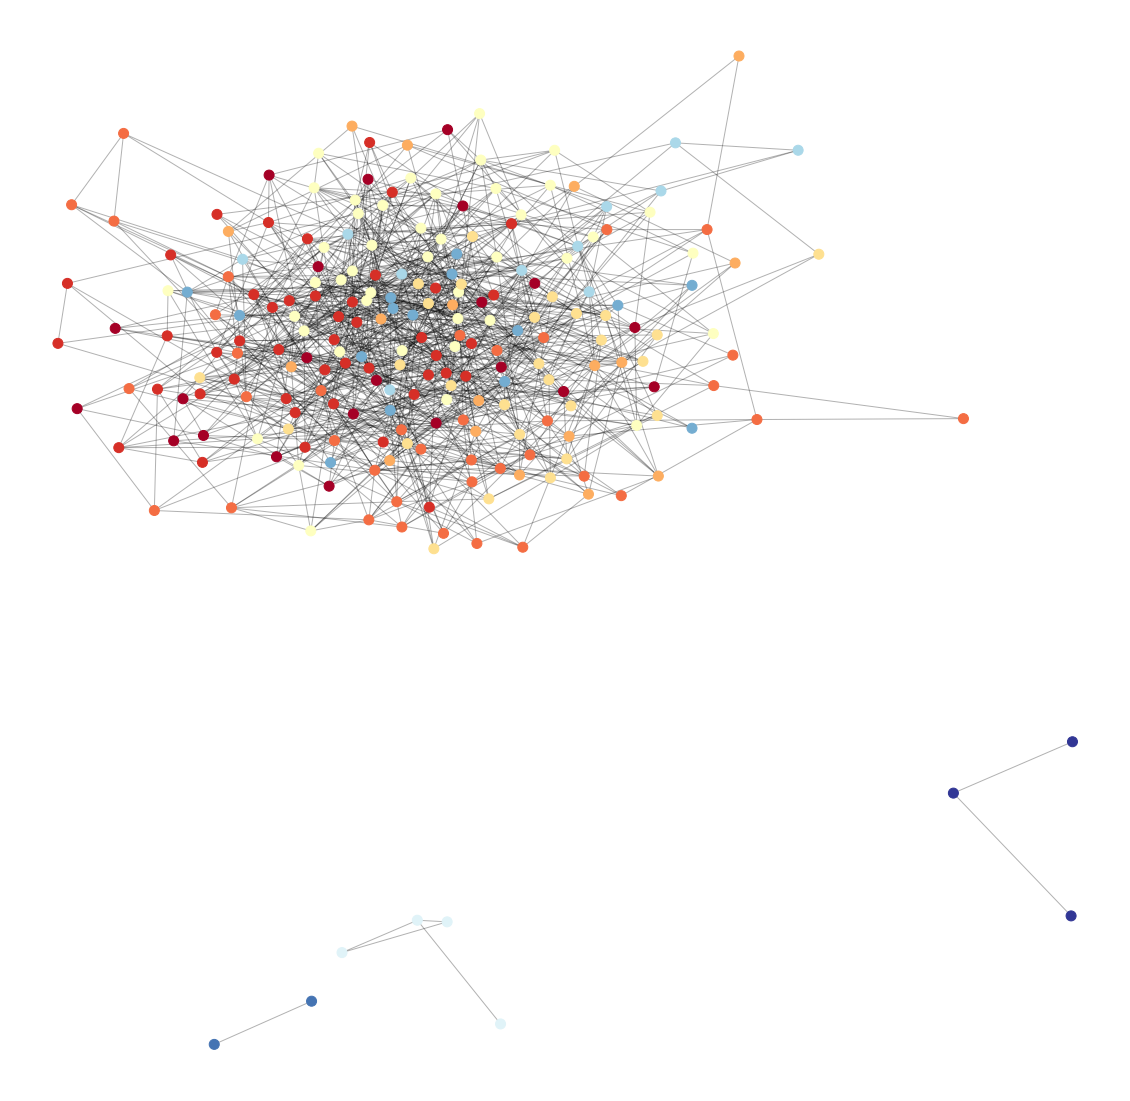

In [24]:
# compute graph layout
#pos = nx.kamada_kawai_layout(G)
#pos = nx.random_layout(G) 
pos = nx.spring_layout(G, k=0.2, pos=None, fixed=None, iterations=50, threshold=0.0001, weight='weight', scale=1, center=None, dim=2, seed=7) 
#pos = nx.circular_layout(G)  
#pos = nx.shell_layout(G)
plt.figure(figsize=(20, 20))  # image size
plt.axis('off')
nx.draw_networkx_nodes(G, pos, node_size=100, cmap=plt.cm.RdYlBu, node_color=list(partition.values()))
nx.draw_networkx_edges(G, pos, alpha=0.3)
i =1
plt.savefig('./community/Louvain/Day%d.png'%i)
plt.show()